<img src='https://certificate.tpq.io/quantsdev_banner_color.png' width="250px" align="right">

# Reinforcement Learning

**Hedging of Options &mdash; WORK IN PROGRESS**

&copy; Dr Yves J Hilpisch | The Python Quants GmbH

[quants@dev Discord Server](https://discord.gg/uJPtp9Awaj) | [@quants_dev](https://twitter.com/quants_dev) | <a href="mailto:qd@tpq.io">qd@tpq.io</a>

<img src="https://hilpisch.com/aiif_cover_shadow.png" width="300px" align="left">

## Reinforcement Learning

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings as w
w.simplefilter('ignore')

## `TensorFlow/Keras`

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.4.0-rc0'

In [7]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [8]:
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

## Q-Learning

See https://keon.io/deep-q-learning/

In [9]:
from collections import deque

In [10]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=keras.optimizers.Adam, lr=0.001):
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.action_space = env.action_space
        self.model = self._build_model(hu, opt, lr)
        
    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(self.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model
    
    def opt_action(self, state):
        bnds = [(0, 1)]
        def f(state, a):
            state[0, 3] = a
            state[0, 4] = state[0, 2] - a * state[0, 0]
            return self.model.predict(state)[0]
        action = minimize(lambda a: -f(state, a), 0.5,
                          bounds=bnds, method='Powell')['x'][0]
        return action
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.opt_action(state)
        return action
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                action = self.opt_action(next_state)
                next_state[0, 3] = action
                next_state[0, 4] = next_state[0, 2] - action * next_state[0, 0]
                reward += self.gamma * self.model.predict(next_state)[0]
            reward = np.array(reward).reshape(1, -1)
            self.model.fit(state, reward, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        self.trewards = []
        self.max_treward = -10000
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            treward = 0
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                treward += reward
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:7.3f} | '
                    templ += 'av: {:6.1f} | best: {:.3f}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')

                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            treward = 0
            state = env.reset()
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = self.opt_action(state)
                next_state, reward, done, info = env.step(action)
                treward += reward
                state = next_state
                if done:
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:.2f}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

## Hedge Environment

In [11]:
from bsm import bsm_call_value
from scipy.optimize import minimize

In [12]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [13]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.random()

In [14]:
class Finance:
    def __init__(self, symbol, S0, K_, T, r_, sigma_, steps):
        self.symbol = symbol
        self.initial_value = S0
        self.strike_ = K_
        self.maturity = pd.Timestamp(T)
        self.short_rate_ = r_
        self.volatility_ = sigma_
        self.steps = steps
        self.observation_space = observation_space(5)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._simulate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0
    def _simulate_data(self):
            s = [self.initial_value]
            self.strike = random.choice(self.strike_)
            self.short_rate = random.choice(self.short_rate_)
            self.volatility = random.choice(self.volatility_)
            self.dt = 1 / self.steps  # "one year" as the default assumption
            for t in range(1, self.steps + 1):
                s_ = s[t - 1] * math.exp(
                    ((self.short_rate - 1 / 2 * self.volatility ** 2) * self.dt +
                      self.volatility * math.sqrt(self.dt) * random.gauss(0, 1))
                )
                s.append(s_)
            self.data = pd.DataFrame(s, columns=[self.symbol],
                                    index=pd.date_range(start='2022-1-1',
                                                        end='2023-1-1',
                                                        periods=self.steps+1))
    def _get_state(self):
        St = self.data[self.symbol].iloc[self.bar]
        ttm = (self.maturity - self.data.index[self.bar]).days / 365
        C = bsm_call_value(St, self.strike, ttm, self.short_rate, self.volatility)
        return np.array([St, ttm, C, self.stock, self.bond])
    def seed(self, seed=None):
        pass
    def reset(self):
        self.bar = 0
        self.bond = 0
        self.stock = 0
        self.treward = 0
        self.episode += 1
        self._simulate_data()
        self.state = self._get_state()
        return self.state
    def step(self, action):
        if self.bar == 0:
            reward = 0
            self.bar += 1
            self.stock = float(action)
            self.bond = self.state[2] - self.stock * self.state[0]
            self.new_state = self._get_state()
        else:
            self.bar += 1
            self.new_state = self._get_state()
            portfolio = (self.stock * self.new_state[0] +
                         self.bond * math.exp(self.short_rate * self.dt))
            pl = portfolio - self.new_state[2]
            df = pd.DataFrame({'e': self.episode, 's': self.stock, 'b': self.bond,
                               'phi': portfolio, 'V': self.new_state[2],
                               'p&l[$]': pl, 'p&l[%]': pl / self.new_state[2] * 100,
                               'St': self.new_state[0], 'K': self.strike,
                               'r': self.short_rate, 'sigma': self.volatility}, index=[0])
            self.portfolios = self.portfolios.append(df, ignore_index=True)
            # reward = -abs(portfolio - self.new_state[2])
            # reward = -min(abs(portfolio / self.new_state[2] - 1) * 100, 100)
            reward = -min(abs(portfolio / self.new_state[2] - 1), 1)
            self.stock = float(action)
            self.bond = self.new_state[2] - self.stock * self.new_state[0]
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        info = {}
        self.state = self.new_state
        return self.state, float(reward), done, info

## Learning

In [15]:
env = Finance('stock', S0=1., K_=[0.9, 0.95, 1, 1.05, 1.1],
              T='2023-1-10', r_=[0, 0.01, 0.05],
              sigma_=[0.1, 0.15, 0.2], steps=365) 

In [16]:
# set_seeds(100)
agent = DQLAgent(gamma=0.95, hu=24, opt=keras.optimizers.Adam, lr=0.0001)

In [17]:
episodes = 50

In [18]:
%time agent.learn(episodes)

episode:   50/50 | treward: -12.550 | av:  -53.7 | best: -5.19847
CPU times: user 2min 2s, sys: 16.7 s, total: 2min 18s
Wall time: 1min 55s


In [19]:
agent.epsilon

0.778312557068642

## Testing

In [20]:
agent.test(3)

[-43.12575006668481, -10.6922933905713, -10.69922552549795]

In [21]:
n = max(env.portfolios['e'])
n -= 1

In [22]:
p = env.portfolios[env.portfolios['e'] == n].iloc[0][['K', 'r', 'sigma']]

In [23]:
title = f"CALL | K={p['K']} | r={p['r']} | sigma={p['sigma']}"

In [24]:
env.portfolios[env.portfolios['e'] == n].tail().round(6)

,e,s,b,phi,V,p&l[$],p&l[%],St,K,r,sigma
18923,52,0.0,0.099298,0.099298,0.098502,0.000796,0.807798,0.998501,0.9,0.0,0.15
18924,52,0.0,0.098502,0.098502,0.098708,-0.000206,-0.208355,0.998707,0.9,0.0,0.15
18925,52,0.0,0.098708,0.098708,0.108256,-0.009548,-8.819885,1.008256,0.9,0.0,0.15
18926,52,0.0,0.108256,0.108256,0.109663,-0.001407,-1.283055,1.009663,0.9,0.0,0.15
18927,52,0.0,0.109663,0.109663,0.111227,-0.001564,-1.405999,1.011227,0.9,0.0,0.15


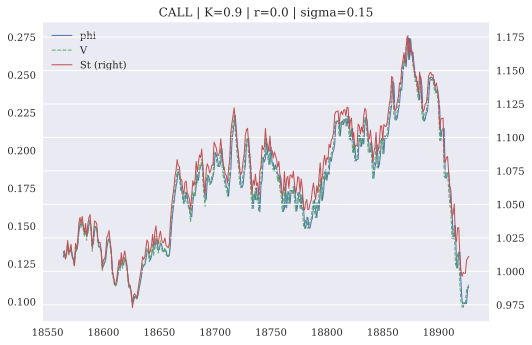

In [25]:
env.portfolios[env.portfolios['e'] == n][['phi', 'V', 'St']].plot(
    secondary_y='St', title=title, style=['-', '--', '-'], lw=1);

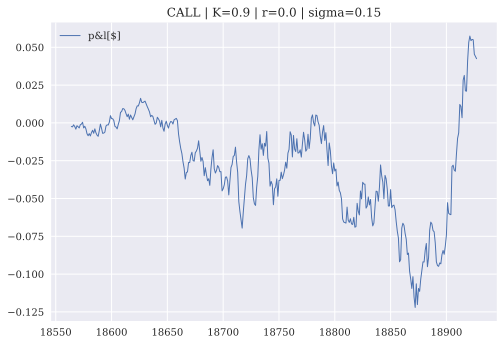

In [26]:
env.portfolios[env.portfolios['e'] == n][['p&l[$]']].cumsum().plot(
    lw=1, title=title);

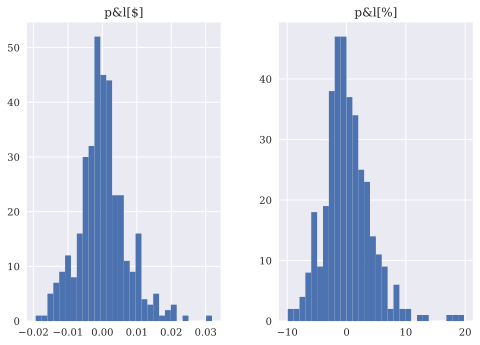

In [27]:
env.portfolios[env.portfolios['e'] == n][['p&l[$]', 'p&l[%]']].hist(bins=30);

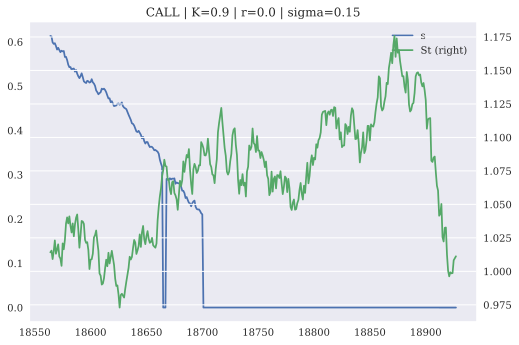

In [28]:
env.portfolios[env.portfolios['e'] == n][['s', 'St']].plot(
    secondary_y='St', title=title);

<img src="https://certificate.tpq.io/quantsdev_banner_color.png" alt="quants@dev" width="35%" align="right" border="0"><br>

[quants@dev Discord Server](https://discord.gg/uJPtp9Awaj) | [@quants_dev](https://twitter.com/quants_dev) | <a href="mailto:qd@tpq.io">qd@tpq.io</a>